In [8]:
import os
import getpass

import os
from typing import Annotated


from dotenv import load_dotenv


from langgraph.graph.message import add_messages
from langsmith import utils 

from IPython.display import Image, display
from typing_extensions import TypedDict, Literal 
from pydantic import BaseModel, Field

from typing import Annotated, List
import operator
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.constants import Send

# 환경 변수 로드
load_dotenv()

utils.tracing_is_enabled()

True

In [9]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

In [10]:
tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return result_str

In [11]:
from typing import Literal
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, END
from langgraph.types import Command

In [12]:
members = ["researcher", "coder"]
options = members + ["FINISH"]

"""
"당신은 다음 작업자들 간의 대화를 관리하는 임무를 맡은 감독자(Supervisor)입니다: {members}.
주어진 사용자 요청(user request)을 바탕으로, 다음 작업을 수행할 작업자(worker)를 선택하여 응답하세요.

각 작업자는 하나의 작업(task)을 수행한 후, 결과(results)와 상태(status)를 반환합니다.
모든 작업이 완료되면 "FINISH"라고 응답하세요."**
"""

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

class Router(TypedDict):
    # 다음으로 라우팅할 작업자. 작업자가 필요하지 않으면 FINISH로 전달
    next: Literal[*options]

# llm 선언
llm = ChatGroq( # model="mixtral-8x7b-32768",
    model="gemma2-9b-it",
    temperature=0.5,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

class State(MessagesState):
    next: str


def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})




In [5]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent

In [13]:
# 작업자 노드 만들기 
research_agent = create_react_agent(
    llm, tools=[tavily_tool], prompt="You are a researcher. DO NOT do any math."
)

def research_node(state: State) -> Command[Literal["supervisor"]]:
    result = research_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )

# 실행 중에 임의의 코드를 실행할 수 있으며,
# 이를 적절히 보호(샌드박스 환경 사용)하지 않으면 보안 위험이 발생할 수 있음
code_agent = create_react_agent(llm, tools=[python_repl_tool])


def code_node(state: State) -> Command[Literal["supervisor"]]:
    result = code_agent.invoke(state)  # LLM 기반 코드 실행 에이전트 호출
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",  # 실행 흐름을 "supervisor" 노드로 이동
    )


builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("researcher", research_node)
builder.add_node("coder", code_node)
graph = builder.compile()

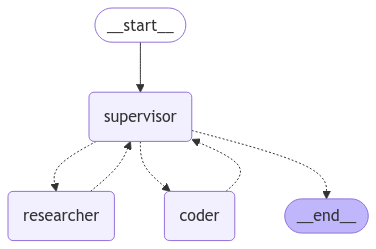

In [14]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
for s in graph.stream(
    {"messages": [("user", "What's the square root of 42?")]}, subgraphs=True
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'researcher'}})
----
(('researcher:2295ee29-136e-ee42-f2cb-03860cc39711',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_152d', 'function': {'arguments': '{"query":"What\'s the square root of 42"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 96, 'prompt_tokens': 1006, 'total_tokens': 1102, 'completion_time': 0.174545455, 'prompt_time': 0.057092628, 'queue_time': 0.041383183, 'total_time': 0.231638083}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-7a580831-f761-4c37-b0bd-45e4ea58e6b7-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': "What's the square root of 42"}, 'id': 'call_152d', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1006, 'output_tokens': 96, 'total_tokens': 1102})]}})
----
(('researcher:2295ee29-136e-ee42-f2cb-0

Python REPL can execute arbitrary code. Use with caution.


(('coder:931a449c-f697-4b1d-6494-9e96f2f145ab',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_x2e4', 'function': {'arguments': '{"code":"import math\\nprint(math.sqrt(42))"}', 'name': 'python_repl_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 94, 'prompt_tokens': 1042, 'total_tokens': 1136, 'completion_time': 0.170909091, 'prompt_time': 0.043729106, 'queue_time': 0.024743539000000002, 'total_time': 0.214638197}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f0decf67-8556-4990-bac3-62f603f1ce67-0', tool_calls=[{'name': 'python_repl_tool', 'args': {'code': 'import math\nprint(math.sqrt(42))'}, 'id': 'call_x2e4', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1042, 'output_tokens': 94, 'total_tokens': 1136})]}})
----
(('coder:931a449c-f697-4b1d-6494-9e96f2f145ab',), {'tools': {'messages': [ToolMessage(content='Su

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [16]:
for s in graph.stream(
    {
        "messages": [
            (
                "user",
                "Find the latest GDP of New York and California, then calculate the average",
            )
        ]
    }, {"recursion_limit": 5},
    subgraphs=True,
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'researcher'}})
----
(('researcher:4f64c806-f06e-4413-36a7-a168e0e20e2b',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_14ke', 'function': {'arguments': '{"query":"latest GDP of New York"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 90, 'prompt_tokens': 1009, 'total_tokens': 1099, 'completion_time': 0.163636364, 'prompt_time': 0.055912935, 'queue_time': 0.023468658000000003, 'total_time': 0.219549299}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-75202673-77ea-4078-afe0-e591d8586197-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'latest GDP of New York'}, 'id': 'call_14ke', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1009, 'output_tokens': 90, 'total_tokens': 1099})]}})
----
(('researcher:4f64c806-f06e-4413-36a7-a168e

GraphRecursionError: Recursion limit of 5 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT